# Optimisation solutions
The optimum solution for each week differs. To improve converge quality and speed, the optimum for each week shall be calculated and stored

In [1]:
# imports
import json
import os
import time
import warnings
from cProfile import Profile
from pstats import SortKey, Stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from src.grid import Grid
from src.generators import (
    SolarGenerator,
    WindGenerator,
    NuclearGenerator,
    CoalGenerator,
    GasGenerator,
)
from src.utils import WEEK_MAP

In [2]:
profile = Profile()
profile.enable()

# initialise dictionary of optimum initialisations
opt_init_weekly = {}

# loop over each week
for week in tqdm(WEEK_MAP["week"]):
    print(week)
    # initialise grid for current week
    grid = Grid(
        generators={
            "solar": SolarGenerator,
            "wind": WindGenerator,
            "nuclear": NuclearGenerator,
            "gas": GasGenerator,
            "coal": CoalGenerator,
        },
        week=week,
    )

    # save successul optimisations and print unsuccessful ones
    if grid.optimum is not None:
        opt_init_weekly[int(week)] = {
            **{
                k: v / grid.demand.max()
                for k, v in grid.optimum["installed_capacity"].items()
            },
            **{"score": grid.optimum["score"]},
        }
    else:
        warnings.warn(f"No optimum found")

profile.disable()

  0%|          | 0/52 [00:00<?, ?it/s]

1


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


2
3
4
5
6
7
8


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


9
10
11
12


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(
/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: COBYLA and init values: optimal
  warnings.warn(
/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: conservative
  warnings.warn(


13


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


14
15


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


16
17
18


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


19
20
21
22
23


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


24
25
26
27


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


28
29


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


30


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


31


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


32
33
34
35
36


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


/Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:136: UserWarning: Optimiser failed with method: SLSQP and init values: optimal
  warnings.warn(


52


In [3]:
# display profiler information on most time consuming functions
Stats(profile).sort_stats(SortKey.TIME).print_stats(0.03)

         943104758 function calls (934672201 primitive calls) in 726.527 seconds

   Ordered by: internal time
   List reduced from 1444 to 43 due to restriction <0.03>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 97831160   51.217    0.000   59.049    0.000 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/env/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:154(maybe_box_datetimelike)
   662120   48.160    0.000   49.659    0.000 {pandas._libs.lib.fast_multiget}
   182096   41.235    0.000   71.635    0.000 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/env/lib/python3.11/site-packages/numpy/lib/function_base.py:1324(diff)
   579355   33.954    0.000   93.002    0.000 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/env/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:875(<dictcomp>)
   629183   33.555    0.000   34.065    0.000 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/env/lib/python3.11/site-packages/pan

In [4]:
# display profiler information on most time consuming functions/sub functions
Stats(profile).sort_stats(SortKey.CUMULATIVE).print_stats(0.03)

         943104758 function calls (934672201 primitive calls) in 726.527 seconds

   Ordered by: cumulative time
   List reduced from 1444 to 43 due to restriction <0.03>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000  726.527  242.176 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3514(run_code)
     11/3    0.000    0.000  726.527  242.176 {built-in method builtins.exec}
      156    0.001    0.000  726.261    4.656 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:54(optimum)
       67    0.000    0.000  726.253   10.840 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/src/grid.py:102(optimise)
       67    0.002    0.000  726.252   10.840 /Users/RDIB/Documents/GitHub/energy-grid-balancing-game/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:51(minimize)
    16566    0.060    0.000  721.498    0.044 /Users/RDIB/Documen

In [5]:
for week in tqdm(WEEK_MAP["week"]):
    assert week in opt_init_weekly

  0%|          | 0/52 [00:00<?, ?it/s]

In [6]:
# save file
with open(os.path.join(os.getcwd(), "weekly_optimum.json"), "w") as f:
    f.write(json.dumps(opt_init_weekly))

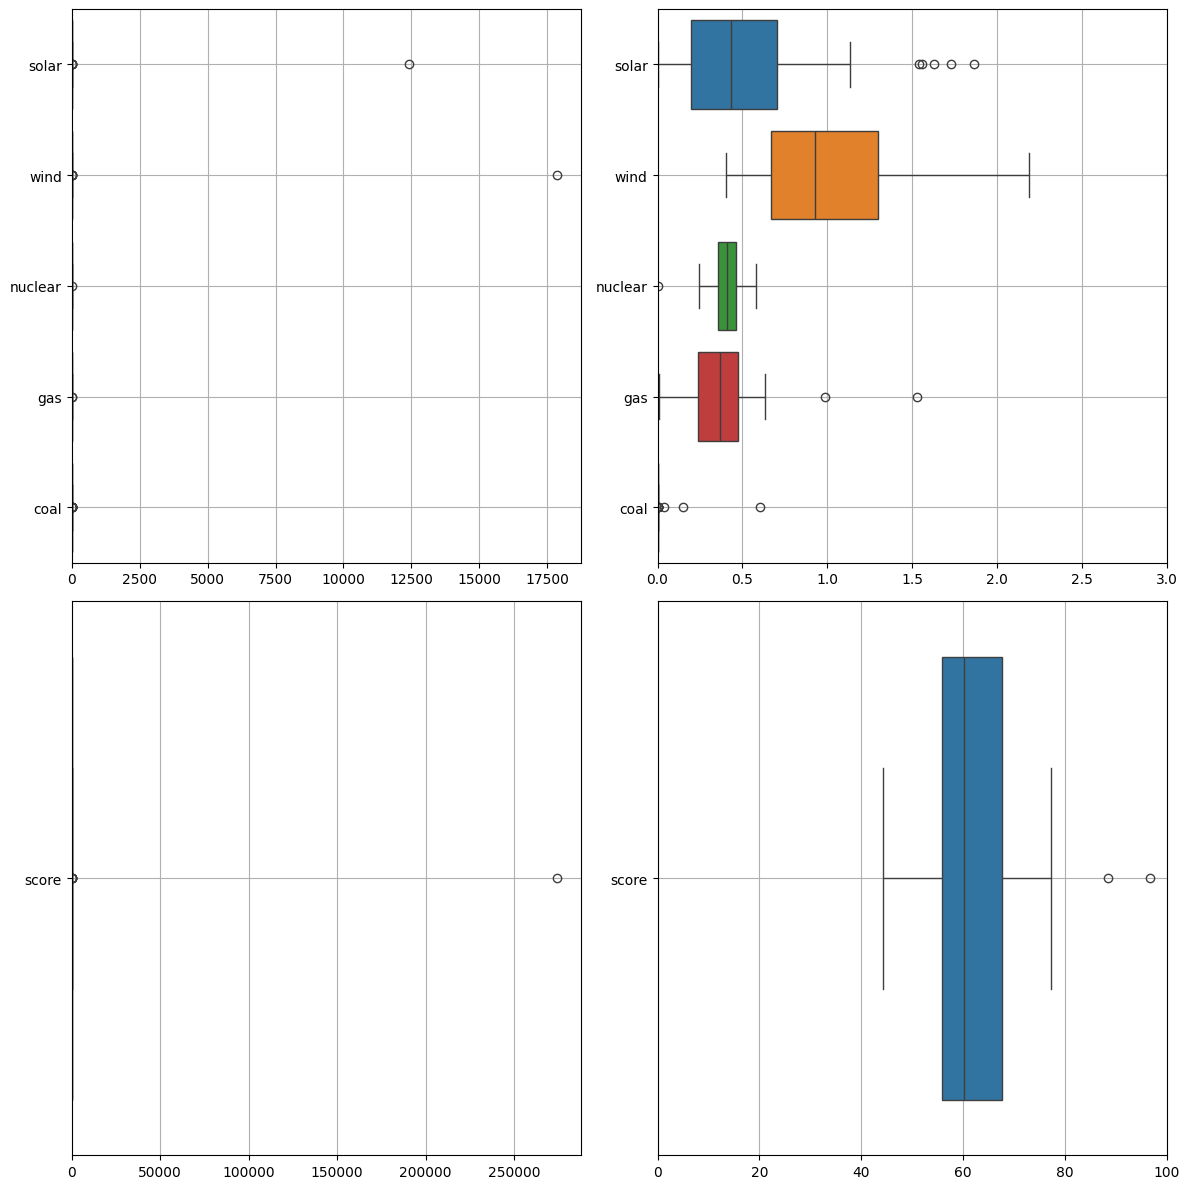

In [7]:
# plot results
df = pd.DataFrame(opt_init_weekly).T
fig, ax_all = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
for data, ax_row in zip(
    [df.drop(columns="score"), df[["score"]]],
    [[ax_all[0, 0], ax_all[0, 1]], [ax_all[1, 0], ax_all[1, 1]]],
):
    for ax in ax_row:
        sns.boxplot(data=data, orient="h", ax=ax)
        ax.grid()
ax_all[0, 0].set_xlim(left=0)
ax_all[1, 0].set_xlim(left=0)
ax_all[0, 1].set_xlim(left=0, right=3)
ax_all[1, 1].set_xlim(left=0, right=100)
fig.tight_layout()